In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep  7 18:35:34 2021

This code refers to:
https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/
http://neuralnetworksanddeeplearning.com/chap1.html


@author: Ziyang Xie
"""
from random import randrange
from math import exp
from random import seed
from random import random
import numpy as np
import matplotlib.pyplot as plt
import collections

In [2]:
'''
For the simplest case, we create one hidden layer. This hidden layer has n_hidden neurons, 
and each neurons has n_inputs + 1 (1 for bias) weights. Similarly, each output neuron has n_hidden + 1 weights.
'''
def init_network(n_inputs, n_hidden, n_outputs):
    network = []
    hidden_layer = [{'weights': [random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    network.append(hidden_layer)
    output_layer = [{'weights': [random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
    return network

In [3]:
'''
Based on this equation: activation = sum(weight_i * input_i) + bias
Quite simple!
'''
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights) - 1):#last element is the bias
        activation += weights[i] * inputs[i]
    return activation

In [4]:
'''
We use sigmoid activation here. 
Commonly-used activation functions:
https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6
'''
def transfer(activation):
    return 1.0 / (1.0 + exp(-activation))


In [5]:
'''
for each layer, it receives previous layer's outputs as input, and calculates it's output by activation / tranfer function. Thin function returns the ouputs from the last layer (output layer)
'''
def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs

In [6]:
'''
Now it comes to the backpropagation , we first need to calculate the derivative of sigmoid transfer funtion.
'''
def transfer_derivative(output):
	return output * (1.0 - output)

In [7]:
'''
We first calculate the error signal from each neuron and save it with the name delta.
Please note that in the last layer, the error is (expected value of the output - output of the output layer). Then, the error signal propagage back to the previous layers by
	
error = (weight_k * error_j) * transfer_derivative(output)

Where error_j is the error signal from the jth neuron in the output layer, weight_k is the weight that connects the kth neuron to the current neuron and output is the output for the current neuron.
'''
def backward_propagate_error(network, expected):
    for i in range(len(network) - 1, -1, -1):#reverse range
        layer = network[i]
        errors = []
        if i != len(network) - 1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

In [8]:
'''
After the errors are calculated for each neuron, we can use these errors to update weights:
    	
weight = weight + learning_rate * error * input

Where weight is a given weight, learning_rate is a parameter that you must specify, error is the error calculated by the backpropagation procedure for the neuron and input is the input value that caused the error.

'''
def update_weights(network, row, l_rate):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
            neuron['weights'][-1] += l_rate * neuron['delta'] #update the weights of bias

In [9]:
'''
Here, the network is updated using stochastic gradiant descent (online gradiant descent), This is because updates are made for each pattern, If errors were accumulated across an epoch before updating the weights, this is called batch learning or batch gradient descent (which is commonly used in large-scale networks and need a batch size parameter).

The sum squared error between the expected output and the network output is accumulated each epoch and printed. This is helpful to create a trace of how much the network is learning and improving each epoch.
'''
def train(network, train, l_rate, n_epoch, n_outputs):
    for epoch in range(n_epoch):
        sum_error = 0
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[row[-1]] = 1
            sum_error += sum([(expected[i] - outputs[i]) ** 2 for i in range(len(expected))])
            backward_propagate_error(network, expected)
            update_weights(network, row, l_rate)
        if not epoch % 50:#print every 50 epoches
            print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))

In [10]:

'''
Using this plot function, you can see the distribution of two data sets
'''

def plot_data(dataset,color = 'r'):
    d = collections.defaultdict(list)
    for x, y, data_type in dataset:
        d[data_type].append([x,y])
    for key in d.keys():
        data = np.transpose(np.array(d[key]))
        plt.scatter(data[0],data[1], label = key)
    plt.legend()
        




In [11]:
'''
In general, it is good to normalize input values to the range of transfer function (our sigmoid funciton ranges between 0 and 1). Therefore, we need a helper function to normalize the input.
'''
def normalize_dataset(dataset):
    stats = [[min(column), max(column)] for column in zip(*dataset)]
    for row in dataset:
            for i in range(len(row)-1):
                row[i] = (row[i] - stats[i][0]) / (stats[i][1] - stats[i][0])

In [12]:
'''
Apply k-folds cross validation. Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data
For more details:
https://machinelearningmastery.com/k-fold-cross-validation/
'''
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [13]:
'''
Calculate accuracy percentage
'''
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [14]:
'''
Evaluate algorithm using cross validation split
'''
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

In [15]:

'''
Make predictions
'''
def predict(network, row):
    outputs = forward_propagate(network, row)
    return outputs.index(max(outputs))

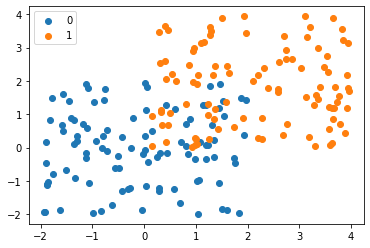

In [16]:
'''
Create a toy dataset (change these parameters and see how our network performs), and do a pilot test.
'''
seed(1)
x1_base, y1_base, x2_base, y2_base = 0, 0, 2, 2
x1_rand, y1_rand, x2_rand, y2_rand = 4, 4, 4, 4
type_1data = [[x1_base + (random() - 0.5) * x1_rand, y1_base + (random() - 0.5) * y1_rand, 0] for _ in range(100)]
type_2data = [[x2_base + (random() - 0.5) * x2_rand, y2_base + (random() - 0.5) * y2_rand, 1] for _ in range(100)]
dataset =  type_1data + type_2data
plot_data(dataset)


In [17]:
n_inputs = len(dataset[0]) - 1
n_outputs = len(set([row[-1] for row in dataset]))
network = init_network(n_inputs, 5, n_outputs)
train(network, dataset, 0.05, 30, n_outputs)
minmax = normalize_dataset(dataset)


>epoch=0, lrate=0.050, error=157.474


In [18]:
for row in dataset:
    prediction = predict(network, row)
    

In [19]:
'''
Use normalization and k-fold to evaluate our model's performance on toy data
'''
def back_propagation(train_data, test, l_rate, n_epoch, n_hidden):
    n_inputs = len(train_data[0]) - 1
    n_outpus = len(set(row[-1] for row in train_data))
    network = init_network(n_inputs, n_hidden, n_outputs)
    train(network, train_data, l_rate, n_epoch, n_outputs)
    predictions = list()
    for row in test:
        prediction = predict(network, row)
        predictions.append(prediction)
    return(predictions)

normalize_dataset(dataset)
# evaluate algorithm
n_folds = 5
l_rate = 0.3
n_epoch = 200
n_hidden = 5
scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

>epoch=0, lrate=0.300, error=92.064
>epoch=50, lrate=0.300, error=34.411
>epoch=100, lrate=0.300, error=34.058
>epoch=150, lrate=0.300, error=33.873
>epoch=0, lrate=0.300, error=87.026
>epoch=50, lrate=0.300, error=32.849
>epoch=100, lrate=0.300, error=32.537
>epoch=150, lrate=0.300, error=32.229
>epoch=0, lrate=0.300, error=87.941
>epoch=50, lrate=0.300, error=28.591
>epoch=100, lrate=0.300, error=28.174
>epoch=150, lrate=0.300, error=27.905
>epoch=0, lrate=0.300, error=83.079
>epoch=50, lrate=0.300, error=32.709
>epoch=100, lrate=0.300, error=32.236
>epoch=150, lrate=0.300, error=31.941
>epoch=0, lrate=0.300, error=89.900
>epoch=50, lrate=0.300, error=27.259
>epoch=100, lrate=0.300, error=26.777
>epoch=150, lrate=0.300, error=26.450
Scores: [95.0, 90.0, 80.0, 90.0, 75.0]
Mean Accuracy: 86.000%
